# Fraud Detection in Insurance Claims

Insurance fraud has been around since the beginning of insurance organizations.Different types of insurance are prone to different crimes, however, in most cases, it manifests deliberate damage to the insured item or the purpose to obtain goods without paying. Detecting insurance fraud can be difficult since not every claim can be investigated thoroughly.
With the below dataset need to predict whether a claim is fraud or not. 

## 1.Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',None)
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split,cross_val_score, cross_val_predict,RepeatedStratifiedKFold,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm,tree
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy import stats
from sklearn.metrics import accuracy_score,mean_squared_error,recall_score,confusion_matrix,f1_score,roc_curve, auc

## 2.Data Analysis and Cleaning

In [2]:
df = pd.read_csv('insurance_claims.csv')

In [3]:
df.head(4)

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,521585,17-10-2014,OH,250/500,1000,1406.91,0,466132,MALE,MD,craft-repair,sleeping,husband,53300,0,25-01-2015,Single Vehicle Collision,Side Collision,Major Damage,Police,SC,Columbus,9935 4th Drive,5,1,YES,1,2,YES,71610,6510,13020,52080,Saab,92x,2004,Y
1,228,42,342868,27-06-2006,IN,250/500,2000,1197.22,5000000,468176,MALE,MD,machine-op-inspct,reading,other-relative,0,0,21-01-2015,Vehicle Theft,?,Minor Damage,Police,VA,Riverwood,6608 MLK Hwy,8,1,?,0,0,?,5070,780,780,3510,Mercedes,E400,2007,Y
2,134,29,687698,06-09-2000,OH,100/300,2000,1413.14,5000000,430632,FEMALE,PhD,sales,board-games,own-child,35100,0,22-02-2015,Multi-vehicle Collision,Rear Collision,Minor Damage,Police,NY,Columbus,7121 Francis Lane,7,3,NO,2,3,NO,34650,7700,3850,23100,Dodge,RAM,2007,N
3,256,41,227811,25-05-1990,IL,250/500,2000,1415.74,6000000,608117,FEMALE,PhD,armed-forces,board-games,unmarried,48900,-62400,10-01-2015,Single Vehicle Collision,Front Collision,Major Damage,Police,OH,Arlington,6956 Maple Drive,5,1,?,1,2,NO,63400,6340,6340,50720,Chevrolet,Tahoe,2014,Y


In [4]:
df.shape

(1000, 39)

In [5]:
## Analyse the Target variable for imbalance
df['fraud_reported'].value_counts()

N    753
Y    247
Name: fraud_reported, dtype: int64

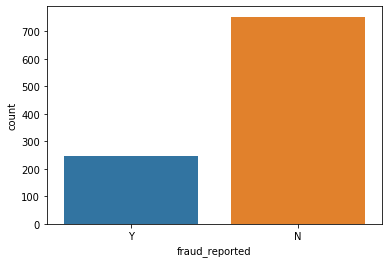

In [6]:
sns.countplot(df['fraud_reported'])

In [7]:
### Data Cleaning
df.isnull().sum()

months_as_customer             0
age                            0
policy_number                  0
policy_bind_date               0
policy_state                   0
policy_csl                     0
policy_deductable              0
policy_annual_premium          0
umbrella_limit                 0
insured_zip                    0
insured_sex                    0
insured_education_level        0
insured_occupation             0
insured_hobbies                0
insured_relationship           0
capital-gains                  0
capital-loss                   0
incident_date                  0
incident_type                  0
collision_type                 0
incident_severity              0
authorities_contacted          0
incident_state                 0
incident_city                  0
incident_location              0
incident_hour_of_the_day       0
number_of_vehicles_involved    0
property_damage                0
bodily_injuries                0
witnesses                      0
police_rep

In [8]:
def missing_values(df):
    missing    = df.isnull().sum()
    missingper = 100*((missing)/len(df))
    missingdf  = pd.concat([missing,missingper],axis=1)
    missingdf.rename({0:'Missing count',1:'Missing Percentange'},inplace=True,axis=1)
    missingdf = missingdf[missingdf['Missing count'] !=0].sort_values('Missing count',ascending=False)
    return missingdf

In [9]:
missing_values(df)

,Missing count,Missing Percentange


In [10]:
## There are no Missing values.

In [11]:
### Analysing Categorical features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 39 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   months_as_customer           1000 non-null   int64  
 1   age                          1000 non-null   int64  
 2   policy_number                1000 non-null   int64  
 3   policy_bind_date             1000 non-null   object 
 4   policy_state                 1000 non-null   object 
 5   policy_csl                   1000 non-null   object 
 6   policy_deductable            1000 non-null   int64  
 7   policy_annual_premium        1000 non-null   float64
 8   umbrella_limit               1000 non-null   int64  
 9   insured_zip                  1000 non-null   int64  
 10  insured_sex                  1000 non-null   object 
 11  insured_education_level      1000 non-null   object 
 12  insured_occupation           1000 non-null   object 
 13  insured_hobbies    

In [12]:
cat =[]
num =[]
for i in df.columns:
    if df[i].dtype == 'object':
        cat.append(i)
    else:
        num.append(i)  

In [13]:
for i in cat:
    print (df[i].value_counts(dropna=False))

28-04-1992    3
05-08-1992    3
01-01-2006    3
25-05-1990    2
04-06-2000    2
             ..
11-11-1996    1
14-11-2014    1
19-09-2012    1
19-09-1991    1
03-02-1999    1
Name: policy_bind_date, Length: 951, dtype: int64
OH    352
IL    338
IN    310
Name: policy_state, dtype: int64
250/500     351
100/300     349
500/1000    300
Name: policy_csl, dtype: int64
FEMALE    537
MALE      463
Name: insured_sex, dtype: int64
JD             161
High School    160
Associate      145
MD             144
Masters        143
PhD            125
College        122
Name: insured_education_level, dtype: int64
machine-op-inspct    93
prof-specialty       85
tech-support         78
exec-managerial      76
sales                76
craft-repair         74
transport-moving     72
priv-house-serv      71
other-service        71
armed-forces         69
adm-clerical         65
protective-serv      63
handlers-cleaners    54
farming-fishing      53
Name: insured_occupation, dtype: int64
reading           64

In [14]:
### Columns with " ? " value need to be replaces

## Replace ? mark of 'collision_type' with "Others"
df['collision_type'].value_counts(dropna=False)
df['collision_type'].replace({'?':'Others'},inplace=True)

## Replace ? mark of 'property_damage' with "Not Defined"
df['property_damage'].value_counts(dropna=False)
df['property_damage'].replace({'?':'Not Defined'},inplace=True)

## Replace ? mark of 'police_report_available' with "Not Mentioned"
df['police_report_available'].value_counts(dropna=False)
df['police_report_available'].replace({'?':'Not Mentioned'},inplace=True)

### 3.Data Visualization

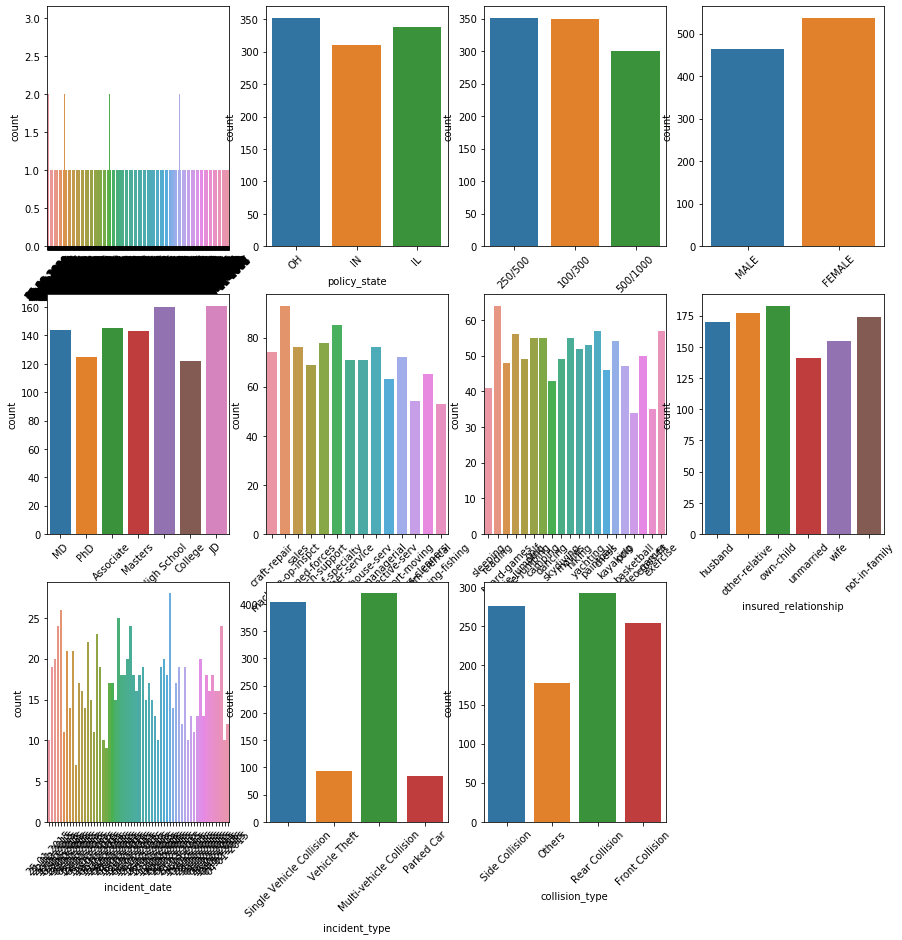

In [15]:
a=cat[0:11]
plt.figure(figsize=(15,15))
for i,j in enumerate(a):
    plt.subplot(3,4,i+1)
    sns.countplot(x=j,data=df)
    plt.xticks(rotation=45)
plt.show()

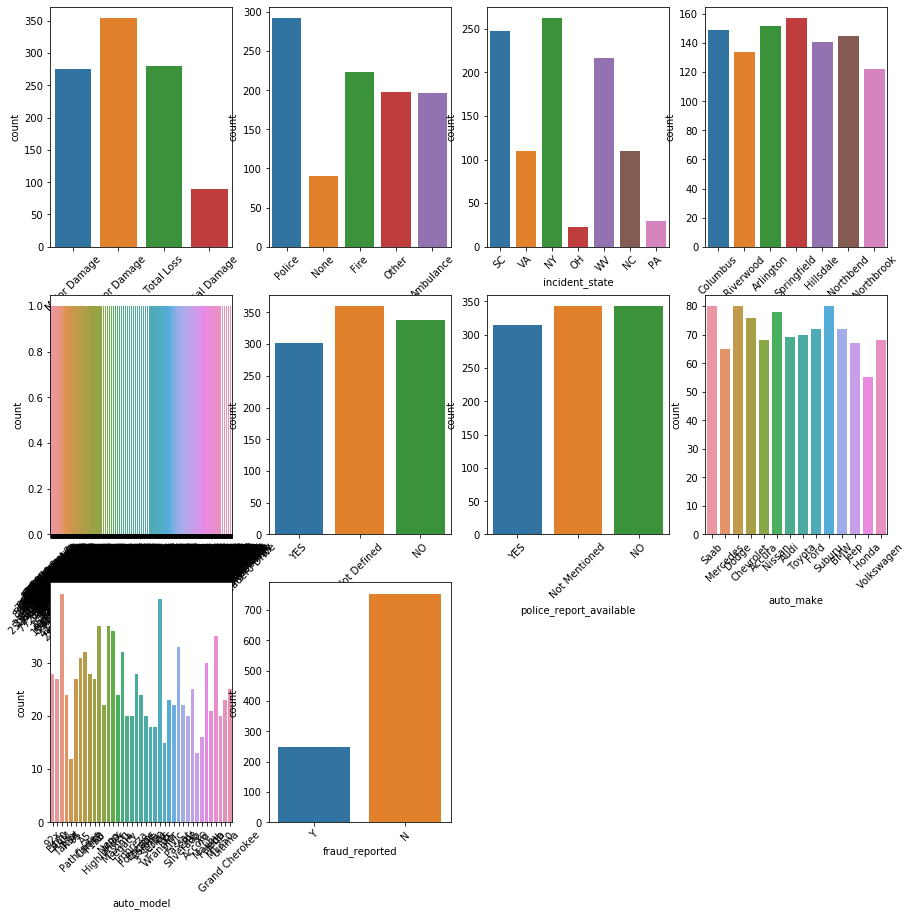

In [16]:
a=cat[11:22]
plt.figure(figsize=(15,15))
for i,j in enumerate(a):
    plt.subplot(3,4,i+1)
    sns.countplot(x=j,data=df)
    plt.xticks(rotation=45)
plt.show()

In [17]:
### Converting dates to datetime format
df['policy_bind_date'] = pd.to_datetime(df['policy_bind_date'])
df['incident_date'] =pd.to_datetime(df['incident_date'])

In [18]:
##Dropping unwanted numerical columns
cols_drop =['policy_number','insured_zip']
df.drop(cols_drop,axis=1,inplace=True)

In [19]:
### Data Visualization
df['fraud_reported']=df['fraud_reported'].map(lambda x : 0 if x=='N' else 1)

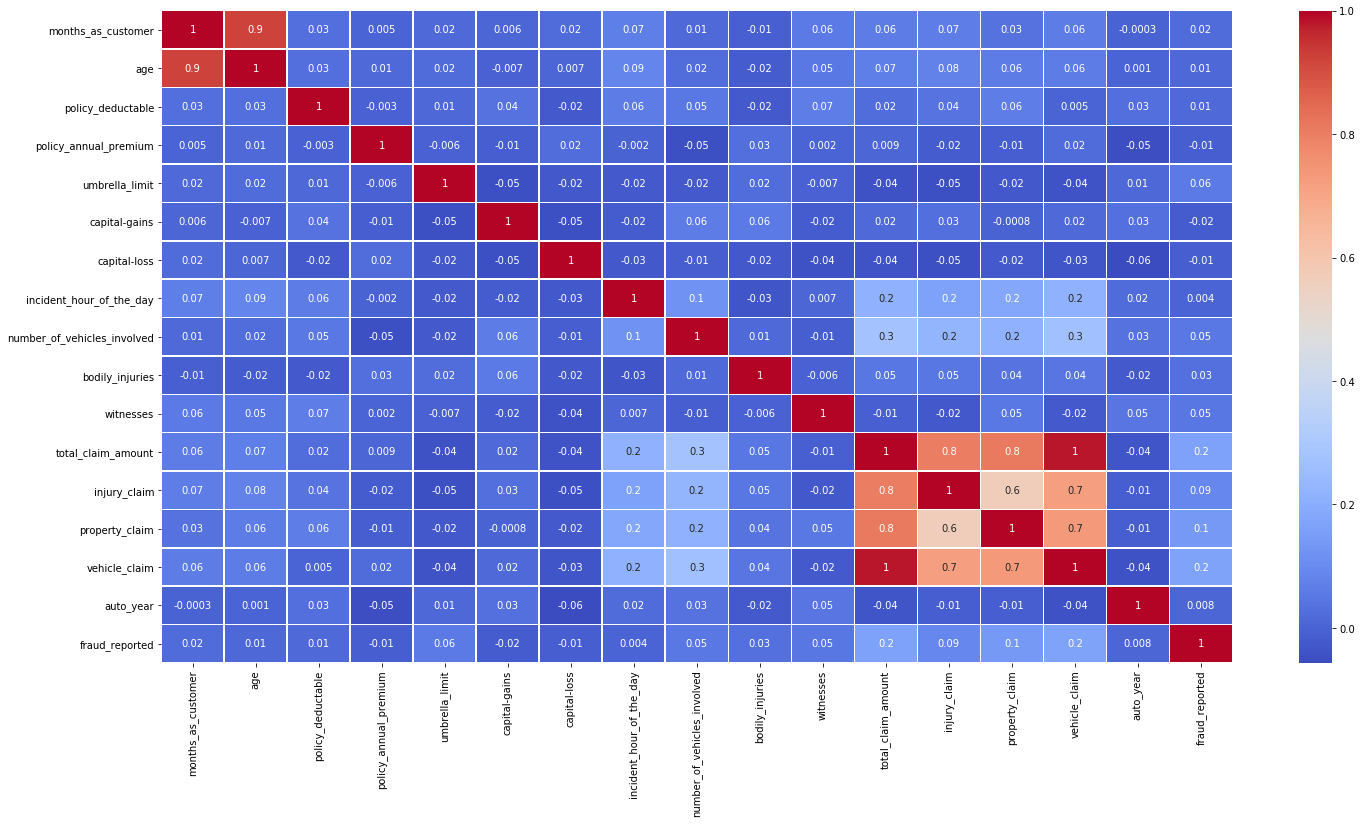

In [20]:
plt.figure(figsize=(24,12))
sns.heatmap(df.corr(),annot=True,fmt='.1g',linewidth=.5,cmap='coolwarm')

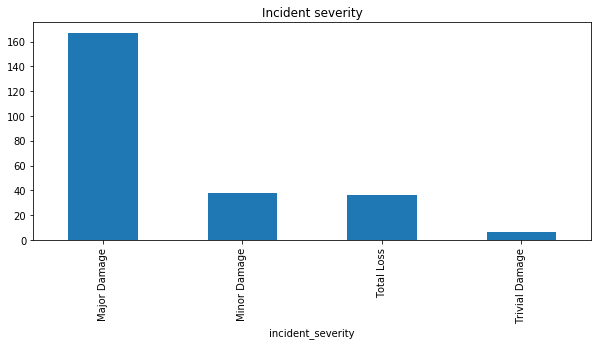

In [102]:
incident_severity =df.groupby('incident_severity')
incident_severity['fraud_reported'].sum().sort_values(ascending=False).plot.bar(figsize=(10,4),title='Incident severity')

People approached company with Major damage committed most of the frauds.

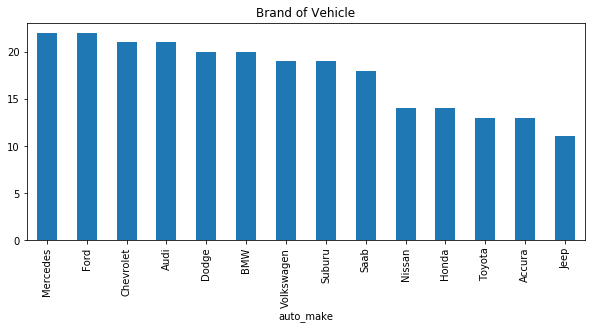

In [98]:
## Which brand having more frauds
automake =df.groupby('auto_make')
automake['fraud_reported'].sum().sort_values(ascending=False).plot.bar(figsize=(10,4),title='Brand of Vehicle')

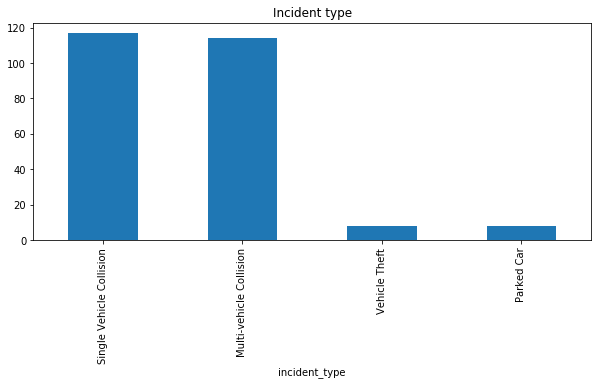

In [101]:
## Checking relation with suthorities_contacted
inci_type =df.groupby('incident_type')
inci_type['fraud_reported'].sum().sort_values(ascending=False).plot.bar(figsize=(10,4),title='Incident type')

 Most of the frauds happend in single and multi vehicle collisions

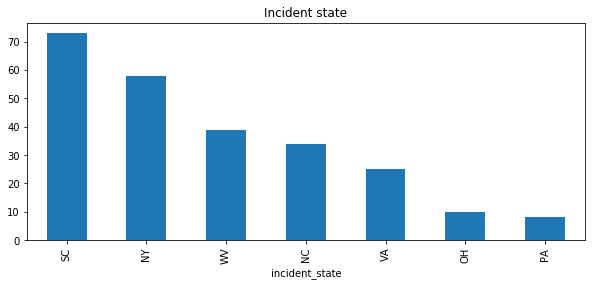

In [100]:
incident_state =df.groupby('incident_state')
incident_state['fraud_reported'].sum().sort_values(ascending=False).plot.bar(figsize=(10,4),title='Incident state')

SC and NY having most of the frauds reported

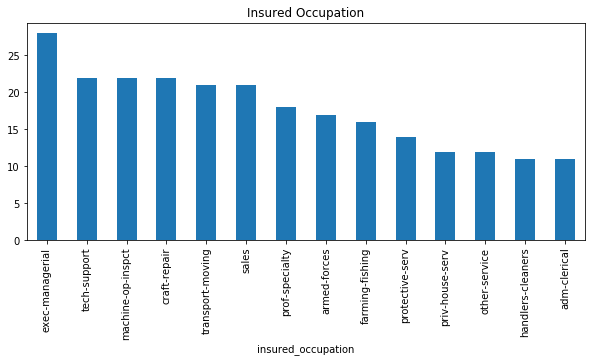

In [103]:
insured_occupation =df.groupby('insured_occupation')
insured_occupation['fraud_reported'].sum().sort_values(ascending=False).plot.bar(figsize=(10,4),title='Insured Occupation')

People working in Exec-Managerial jobs shows most of the crimes associated with

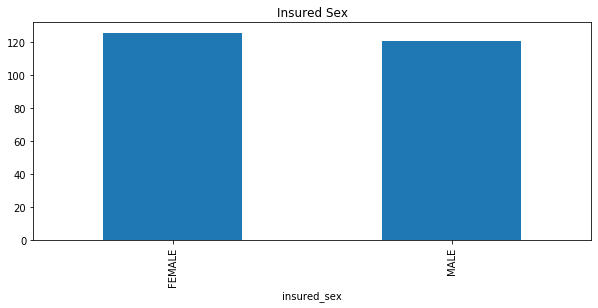

In [104]:
insured_sex = df.groupby('insured_sex')
insured_sex['fraud_reported'].sum().sort_values(ascending=False).plot.bar(figsize=(10,4),title='Insured Sex')

Both male and female count is almost same.But women overtake the fraud count comparing with men.

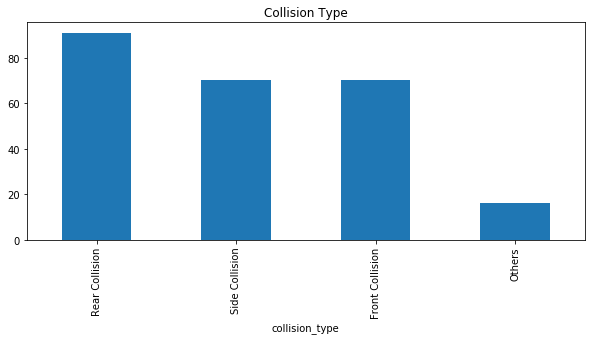

In [105]:
collision_type =df.groupby('collision_type')
collision_type['fraud_reported'].sum().sort_values(ascending=False).plot.bar(figsize=(10,4),title='Collision Type')

Total claim amount and vehicle claim amount so much correlated

In [28]:
data =df.copy()
data['incident_year']= pd.DatetimeIndex(data['incident_date']).year
data['incident_month'] = pd.DatetimeIndex(data['incident_date']).month
data['incident_week_day'] = data['incident_date'].dt.dayofweek
data['incident_month_year'] = pd.to_datetime(data['incident_date']).dt.to_period('M')

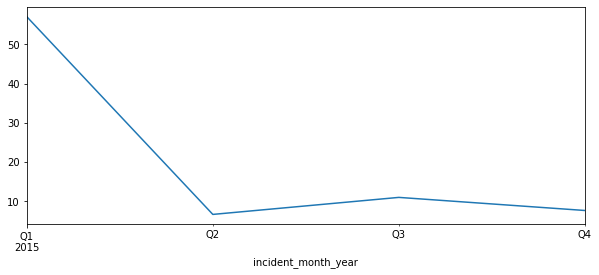

In [29]:
quater= data.groupby('incident_month_year')
quarterfraud=quater['fraud_reported'].sum().resample('Q').mean().plot(figsize=(10,4))

Quarter 1 having most of the frauds

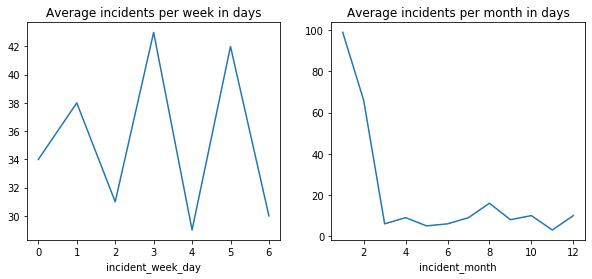

In [30]:
plt.subplot(1, 2, 1)
days=data.groupby("incident_week_day")
days['fraud_reported'].sum().plot(figsize=(10,4),title='Average incidents per week in days')


plt.subplot(1, 2,2 )
days=data.groupby("incident_month")
days['fraud_reported'].sum().plot(figsize=(10,4),title='Average incidents per month in days')


In [31]:
data.head(2)

,months_as_customer,age,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,capital-loss,incident_date,incident_type,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,incident_location,incident_hour_of_the_day,number_of_vehicles_involved,property_damage,bodily_injuries,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,incident_year,incident_month,incident_week_day,incident_month_year
0,328,48,2014-10-17,OH,250/500,1000,1406.91,0,MALE,MD,craft-repair,sleeping,husband,53300,0,2015-01-25,Single Vehicle Collision,Side Collision,Major Damage,Police,SC,Columbus,9935 4th Drive,5,1,YES,1,2,YES,71610,6510,13020,52080,Saab,92x,2004,1,2015,1,6,2015-01
1,228,42,2006-06-27,IN,250/500,2000,1197.22,5000000,MALE,MD,machine-op-inspct,reading,other-relative,0,0,2015-01-21,Vehicle Theft,Others,Minor Damage,Police,VA,Riverwood,6608 MLK Hwy,8,1,Not Defined,0,0,Not Mentioned,5070,780,780,3510,Mercedes,E400,2007,1,2015,1,2,2015-01


Starting of the year having most of the frauds reported
The most number of frauds reported in jan - March followed by August.Highest number of frauds reported in 2015 quarter 1. 
Wednesday recorded highest number of frauds and saturday  with the least number. 

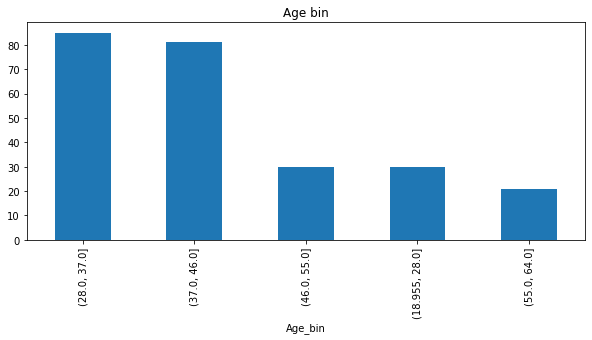

In [106]:
data['Age_bin']=pd.cut(data['age'],bins=5)
Age_bin=data.groupby('Age_bin')
Age_bin['fraud_reported'].sum().sort_values(ascending=False).plot.bar(figsize=(10,4),title='Age bin')

People with age between 28 and 46 had commited most of the frauds comparing with old aged people who is above 55 with the least fraudulant actions.

(-1.1930039074226144,
 1.1050788178461377,
 -1.1049587981765536,
 1.1011191048996987)

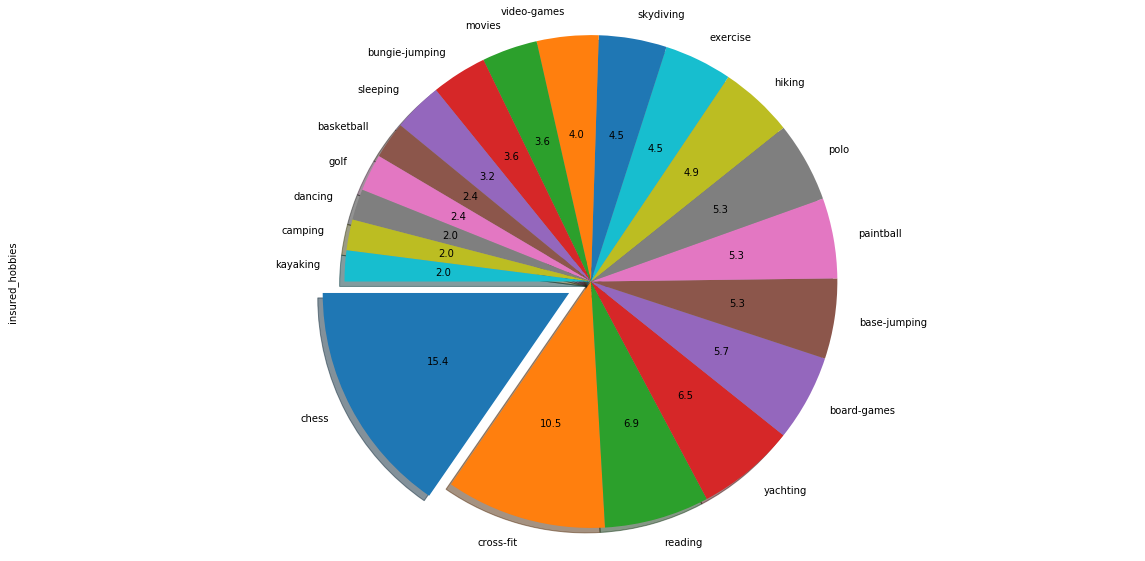

In [33]:
high_fraud =df[(df['fraud_reported']==1)]
fraud=high_fraud['insured_hobbies'].value_counts().plot.pie(figsize=(20,10),
                                                  startangle=180, explode=(0.1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0),autopct='%.1f',shadow=True,)
fraud.axis('equal')


Frauds are mostly done by chess players and Corss_fit players. Those who are brilliant in gaming fall into the fradulent actions

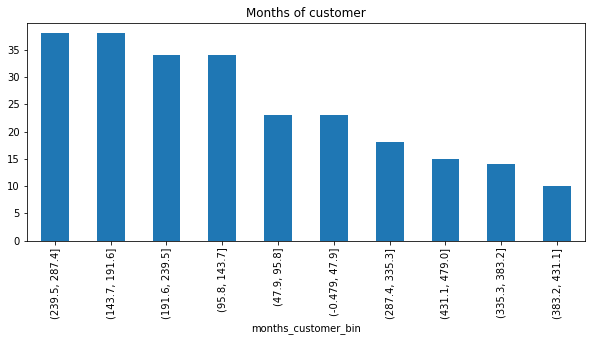

In [107]:
data['months_customer_bin']=pd.cut(data['months_as_customer'],bins=10)
months_customer_bin=data.groupby('months_customer_bin')
months_customer_bin['fraud_reported'].sum().sort_values(ascending=False).plot.bar(figsize=(10,4),title='Months of customer')

Customer with 95 to 280 months of experience with the company committed more crimes , Where customer with less months of experince had less into frauds.

In [35]:
num1 =[]
for i in df.columns:
    if (df[i].dtype == 'int64') | (df[i].dtype == 'float64'):
        num1.append(i) 

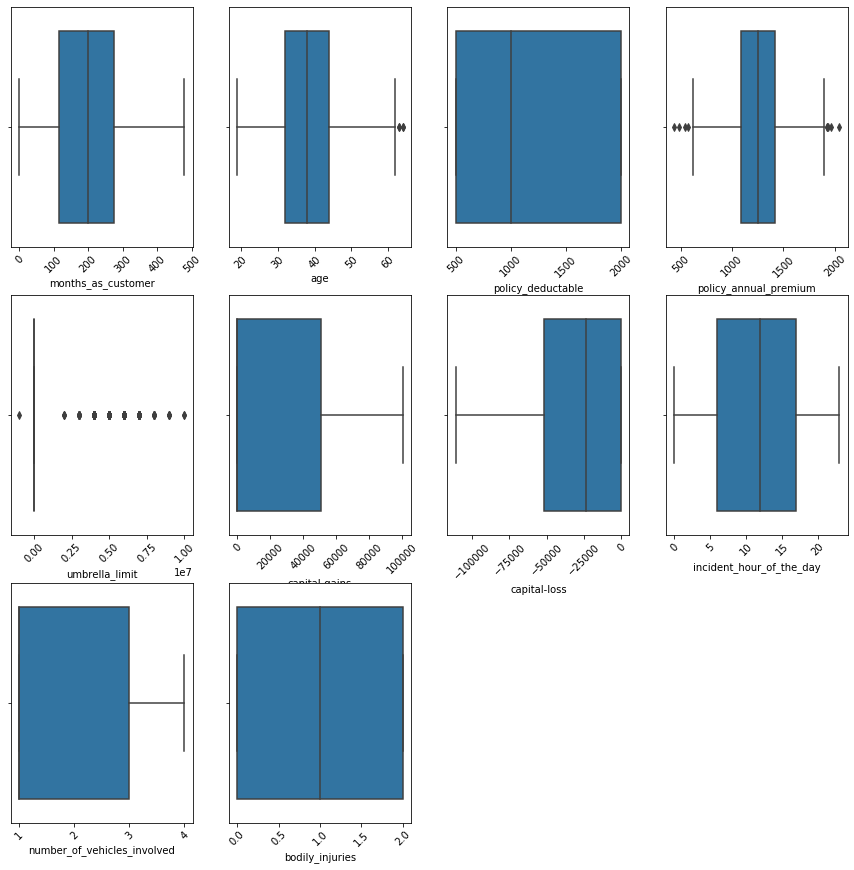

In [36]:
## Outlier Treatment
a=num1[0:10]
plt.figure(figsize=(15,15))
for i,j in enumerate(a):
    plt.subplot(3,4,i+1)
    sns.boxplot(df[j])
    plt.xticks(rotation=45)
plt.show()

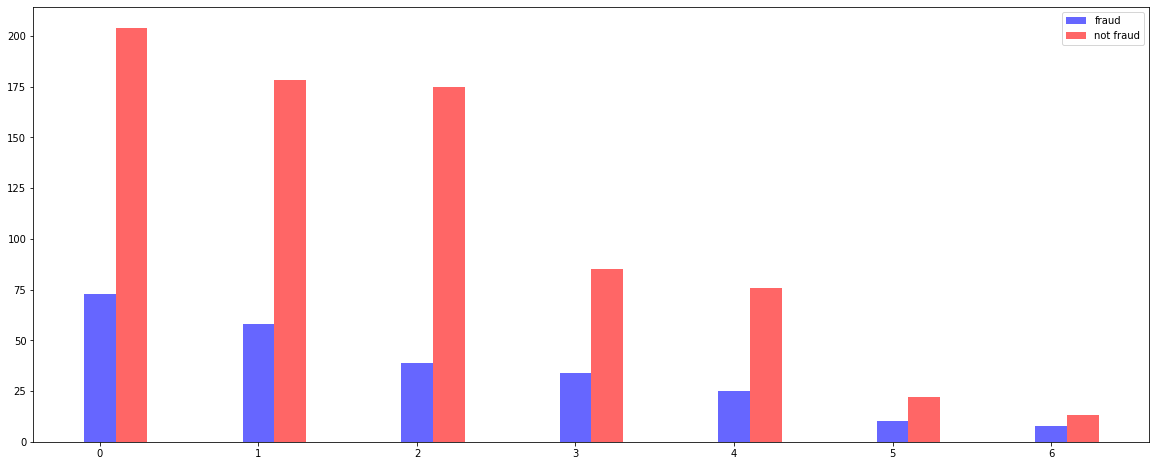

In [37]:
a = df[(df['fraud_reported']== 1)]
b =df [(df['fraud_reported']== 0)]
count1=a['incident_state'].value_counts()
count2=b['incident_state'].value_counts()
state = np.arange(7)
fig,ax = plt.subplots(figsize=(20,8))
bar_width=0.2
opacity=0.6
type1=plt.bar(state,count1,bar_width,alpha=opacity,color='b',label='fraud')
type2=plt.bar(state+bar_width,count2,bar_width,alpha=opacity,color='r',label='not fraud')
plt.legend()
plt.show()

There are no much impacted outliers

### 4.Target Encoding and Standardization

In [38]:
df['Policy_Bind_year']=df['policy_bind_date'].dt.year
df['Policy_Bind_month']=df['policy_bind_date'].dt.month
df['Policy_Bind_day']=df['policy_bind_date'].dt.dayofweek
df['incident_month'] = df['incident_date'].dt.month
df['incident_week_day'] = df['incident_date'].dt.dayofweek
## Drop date columns
drop_cols =['policy_bind_date','incident_date','incident_location']
df.drop(drop_cols,axis=1,inplace=True)

In [39]:
### Encoding
from category_encoders import TargetEncoder
encoder =TargetEncoder()

In [40]:
cat1 =[]
for i in df.columns:
    if df[i].dtype == 'object':
        cat1.append(i) 
df1 =df.copy()
df1[cat1] = encoder.fit_transform(df1[cat1],df1['fraud_reported'])

In [41]:
X =df1.loc[:,df.columns !='fraud_reported']
y=df1['fraud_reported']

In [42]:
### train-test split
df_train,df_test= train_test_split(df1,train_size=0.70,test_size=0.30,random_state=100)

df_train1=df_train.copy()
df_test1 =df_test.copy()
df_y_train = df_train1.pop('fraud_reported')
df_y_test  = df_test1.pop('fraud_reported')
df_X_train = df_train1
df_X_test  = df_test1

In [43]:
y_train = df_train.pop('fraud_reported')
y_test  = df_test.pop('fraud_reported')
X_train = df_train
X_test  = df_test

In [44]:
sc =StandardScaler()
cols = X_train.columns
X_train[cols] = sc.fit_transform(X_train[cols])
X_test[cols] = sc.transform(X_test[cols])

In [45]:
y_test.value_counts()

0    225
1     75
Name: fraud_reported, dtype: int64

### 5.Model Building

In [77]:
def classifiermodel(model,X_train, X_test,y_train,y_test,df_X_test ):
    model=model.fit(X_train,y_train) # Fitting train data for fraud detection
    y_pred=model.predict(X_test)
 
    accuracy=accuracy_score(y_pred, y_test) #Accuracy for fraud detection
    recall =recall_score(y_pred, y_test) #Recall score for  fraud detection
    confus=confusion_matrix(y_test,y_pred)# fraud detection
    f1 = f1_score(y_test,y_pred)#fraud detection
    
    
    track_df_f = df_X_test.copy(deep=True)
    track_df_f['predicted_value'] = y_pred
    track_df_f['actual_value'] = y_test
    
    
    print('Model paramters used are :',model)
    print('Accuracy of fraud status is        :', (accuracy)*100,'%')
    print('Recall score of fraud status is        :', recall)
    print('Conf Matrix of fraud status is        :\n',  (confus))
    print('F1 score of fraud status is        :', f1)
    return model 


### 1.Logistic Classification Model

In [47]:
classifiermodel(LogisticRegression(solver='lbfgs',random_state=0),X_train, X_test,y_train,y_test,df_X_test)

Model paramters used are : LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy of fraud status is        : 84.0 %
Recall score of fraud status is        : 0.6901408450704225
Conf Matrix of fraud status is        :
 [[203  22]
 [ 26  49]]
F1 score of fraud status is        : 0.6712328767123288


### 2.Gaussian naive bayes model

In [48]:
classifiermodel(GaussianNB(),X_train, X_test,y_train,y_test,df_X_test)

Model paramters used are : GaussianNB(priors=None, var_smoothing=1e-09)
Accuracy of fraud status is        : 83.0 %
Recall score of fraud status is        : 0.603448275862069
Conf Matrix of fraud status is        :
 [[179  46]
 [  5  70]]
F1 score of fraud status is        : 0.7329842931937173


### 3.Support vector machines

In [49]:
classifiermodel(svm.LinearSVC(),X_train, X_test,y_train,y_test,df_X_test)

Model paramters used are : LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Accuracy of fraud status is        : 84.66666666666667 %
Recall score of fraud status is        : 0.6986301369863014
Conf Matrix of fraud status is        :
 [[203  22]
 [ 24  51]]
F1 score of fraud status is        : 0.6891891891891893


### 4.K nearest Neighbors classification

In [50]:
classifiermodel(KNeighborsClassifier(n_neighbors=6),X_train, X_test,y_train,y_test,df_X_test)

Model paramters used are : KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                     weights='uniform')
Accuracy of fraud status is        : 79.33333333333333 %
Recall score of fraud status is        : 0.7407407407407407
Conf Matrix of fraud status is        :
 [[218   7]
 [ 55  20]]
F1 score of fraud status is        : 0.39215686274509803


### 5.Linear Discriminant Analysis

In [51]:
Model = classifiermodel(LinearDiscriminantAnalysis(),X_train, X_test,y_train,y_test,df_X_test)

Model paramters used are : LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)
Accuracy of fraud status is        : 86.0 %
Recall score of fraud status is        : 0.6987951807228916
Conf Matrix of fraud status is        :
 [[200  25]
 [ 17  58]]
F1 score of fraud status is        : 0.7341772151898734


### 6.Random forest classification

In [52]:
classifiermodel(RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0),X_train, X_test,y_train,y_test,df_X_test)

Model paramters used are : RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
Accuracy of fraud status is        : 81.33333333333333 %
Recall score of fraud status is        : 0.6938775510204082
Conf Matrix of fraud status is        :
 [[210  15]
 [ 41  34]]
F1 score of fraud status is        : 0.5483870967741935


### 7.Extra trees classification

In [53]:
classifiermodel(ExtraTreesClassifier(max_depth=10),X_train, X_test,y_train,y_test,df_X_test)

Model paramters used are : ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=10, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)
Accuracy of fraud status is        : 82.0 %
Recall score of fraud status is        : 0.6615384615384615
Conf Matrix of fraud status is        :
 [[203  22]
 [ 32  43]]
F1 score of fraud status is        : 0.6142857142857143


### 8.eXtreme Gradient Boosting Classification

In [54]:
classifiermodel(XGBClassifier(),X_train, X_test,y_train,y_test,df_X_test)

Model paramters used are : XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
Accuracy of fraud status is        : 81.33333333333333 %
Recall score of fraud status is        : 0.6376811594202898
Conf Matrix of fraud status is        :
 [[200  25]
 [ 31  44]]
F1 score of fraud status is        : 0.611111111111111


### 9.Decision tree classification

In [55]:
classifiermodel(DecisionTreeClassifier(),X_train, X_test,y_train,y_test,df_X_test)

Model paramters used are : DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy of fraud status is        : 74.0 %
Recall score of fraud status is        : 0.48148148148148145
Conf Matrix of fraud status is        :
 [[183  42]
 [ 36  39]]
F1 score of fraud status is        : 0.5


Considering F1 score it is clear that Linear discriminant classifier is performing better for classification type with F1 score of almost 73% for fraud detection 83% accuracy.Just to make sure that model is predicting correctly the model is cross validated and the results are compared with accuracy of the model.


### 10.RidgeClassifier

In [80]:
ridge_best =classifiermodel(RidgeClassifier(),X_train, X_test,y_train,y_test,df_X_test)

Model paramters used are : RidgeClassifier(alpha=1.0, class_weight=None, copy_X=True, fit_intercept=True,
                max_iter=None, normalize=False, random_state=None,
                solver='auto', tol=0.001)
Accuracy of fraud status is        : 85.33333333333334 %
Recall score of fraud status is        : 0.6962025316455697
Conf Matrix of fraud status is        :
 [[201  24]
 [ 20  55]]
F1 score of fraud status is        : 0.7142857142857143


### 6.Cross validation

In [58]:
def cross_validation(model,X,y):
    model = model.fit(X,y)
    score =cross_val_score(model,X,y,cv=6)
    print('Model used is',model)
    print('Cross validation accuracy of fraud: %0.2f (+/- %0.2f)' % (score.mean(), score.std() * 2))   

In [59]:
cross_validation(LinearDiscriminantAnalysis(),X,y)

Model used is LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)
Cross validation accuracy of fraud: 0.87 (+/- 0.06)


Since, the difference between cross validated scores and accuracy scores of the model is very minimal it can be confirmed that the data is neither overfitted or underfitted, Which variable was given more importance in the model is found using feature importance method from sklearn.

### 7.Feature Importance
Find Feature importance using one of the best model of tree classifier

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37]),
 <a list of 38 Text xticklabel objects>)

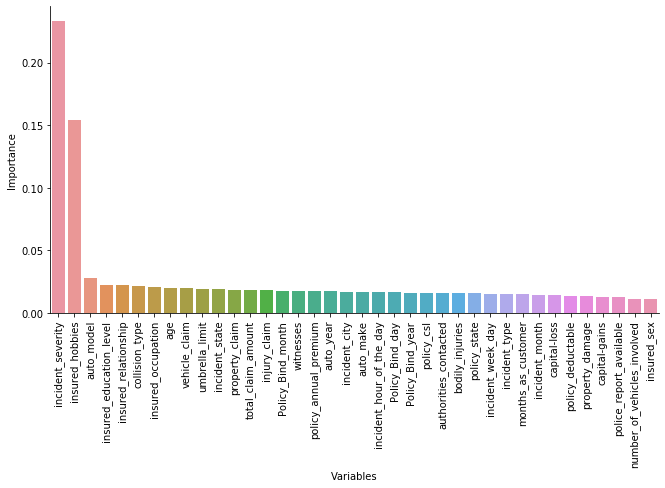

In [60]:
model =ExtraTreesClassifier(max_depth=10)
model.fit(X_train,y_train)
imp_col = model.feature_importances_.argsort()
fea_imp = pd.DataFrame({'Variables':X.columns[imp_col],'Importance':model.feature_importances_[imp_col]})
fea_imp=fea_imp.sort_values(by='Importance',ascending=False)
ax = sns.catplot(x='Variables', y = 'Importance', data=fea_imp, height=5, aspect=2,  kind="bar")
plt.xticks(rotation=90)

With the help of ExtraTreeclassifier(73% F1 score and 84% accuracy), incident_severity and insured_hobbies having more importance of above 0.20.All other factors having importance less than 0.05.it will be interesting to see how well the model can predict when these variables are removed.

In [61]:
new_data = df1.copy()

In [62]:
new_data.drop(['incident_severity','insured_hobbies'],axis=1,inplace=True)

In [63]:
#All columns expect fraud
new_x=new_data.loc[:, new_data.columns != 'fraud_reported']

#Only fraud column
new_y=new_data['fraud_reported']

#Splitting the data into two parts in which 80% data will be used for training the model and 20% for testing
new_x_train, new_x_test,new_y_train,new_y_test = train_test_split(new_x,new_y,test_size = 0.2,random_state = 42)

In [64]:
new_x_train =sc.fit_transform(new_x_train)
new_x_test  =sc.transform(new_x_test)

In [65]:
def new_classifier(model,X_train,y_train,X_test,y_test):
    model = model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    accuracy =accuracy_score(y_pred,y_test)
    recall =recall_score(y_pred,y_test,average='weighted')
    con_mat =confusion_matrix(y_test,y_pred)
    f1 =f1_score(y_test, y_pred,average='weighted')
    print('Model paramters used are :',model)
    print('Accuracy         :', (accuracy)*100,'%')
    print('Recall score        :', (recall)*100,'%')
    print('Conf Matrix        : \n',(con_mat))
    print('F1 score       :', (f1)*100,'%')

In [66]:
#### Applying on different models

In [67]:
new_classifier(LinearDiscriminantAnalysis(),new_x_train, new_y_train,new_x_test,new_y_test)

Model paramters used are : LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)
Accuracy         : 69.0 %
Recall score        : 69.0 %
Conf Matrix        : 
 [[133  12]
 [ 50   5]]
F1 score       : 62.61517615176152 %


In [68]:
new_classifier(ExtraTreesClassifier(max_depth=10),new_x_train, new_y_train,new_x_test,new_y_test)

Model paramters used are : ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=10, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)
Accuracy         : 72.0 %
Recall score        : 72.0 %
Conf Matrix        : 
 [[144   1]
 [ 55   0]]
F1 score       : 60.69767441860465 %


In [69]:
new_classifier(svm.LinearSVC(),new_x_train, new_y_train,new_x_test,new_y_test)

Model paramters used are : LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Accuracy         : 69.0 %
Recall score        : 69.0 %
Conf Matrix        : 
 [[135  10]
 [ 52   3]]
F1 score       : 61.38731396172926 %


In [70]:
new_classifier(LogisticRegression(solver='lbfgs',random_state=0),new_x_train, new_y_train,new_x_test,new_y_test)

Model paramters used are : LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Accuracy         : 69.0 %
Recall score        : 69.0 %
Conf Matrix        : 
 [[133  12]
 [ 50   5]]
F1 score       : 62.61517615176152 %


In [71]:
new_classifier(RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0),new_x_train, new_y_train,new_x_test,new_y_test)

Model paramters used are : RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
Accuracy         : 70.5 %
Recall score        : 70.5 %
Conf Matrix        : 
 [[141   4]
 [ 55   0]]
F1 score       : 59.95601173020528 %


In [72]:
new_classifier(GaussianNB(),new_x_train, new_y_train,new_x_test,new_y_test)

Model paramters used are : GaussianNB(priors=None, var_smoothing=1e-09)
Accuracy         : 58.5 %
Recall score        : 58.5 %
Conf Matrix        : 
 [[72 73]
 [10 45]]
F1 score       : 60.29754780881566 %


From this it is found that there is a gradual drop in F1 score and accuracy of model.Still LinearDiscriminantAnalysis giving comparetevely good score of 62% of F1 ,which is followed by ExtraTreeClassifier

In [73]:
new_classifier(tree.DecisionTreeClassifier(),new_x_train, new_y_train,new_x_test,new_y_test)

Model paramters used are : DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
Accuracy         : 62.0 %
Recall score        : 61.999999999999986 %
Conf Matrix        : 
 [[110  35]
 [ 41  14]]
F1 score       : 61.28898128898128 %


Even Decision Tree Multi Classification Model having F1 score of 62 , which is less than F1 score of LinearDiscriminantAnalysis. 

So the best model would be LinearDiscriminantAnalysis

#### HyperParameter Tuning

In [74]:
model = LinearDiscriminantAnalysis()
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
params_grid = {
              'n_components':[1,2],'shrinkage':np.arange(0, 1, 0.01),'solver':['lsqr']
             }

search = GridSearchCV(model, param_grid=params_grid, scoring='accuracy', cv=cv, n_jobs=-1)

results = search.fit(X_train, y_train)

print('Mean Accuracy: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)


Mean Accuracy: 0.869
Config: {'n_components': 1, 'shrinkage': 0.02, 'solver': 'lsqr'}


In [75]:
y_pred = results.predict(X_test)
accuracy=accuracy_score(y_pred, y_test) #Accuracy for fraud detection
recall =recall_score(y_pred, y_test) #Recall score for  fraud detection
confus=confusion_matrix(y_test,y_pred)# fraud detection
f1 = f1_score(y_test,y_pred)
print('Model paramters used are :',model)
print('Accuracy of fraud status is        :', (accuracy)*100,'%')
print('Recall score of fraud status is        :', recall)
print('Conf Matrix of fraud status is        :\n',  (confus))
print('F1 score of fraud status is        :', f1)

Model paramters used are : LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)
Accuracy of fraud status is        : 86.0 %
Recall score of fraud status is        : 0.6941176470588235
Conf Matrix of fraud status is        :
 [[199  26]
 [ 16  59]]
F1 score of fraud status is        : 0.7374999999999999


# Conclusion

After Analysing the dataset , it has been discovered that ,most of the Frauds reported with Single and Multi vehicle collisions in states SC and NY. It is surprising to see that people with good occupation mainly involved in the Frauds.Although loss reported counts of Male are less, the amount of frauds committed in total by males and females are almost  equal.
Also it is observed that , Starting of the year and mid of the week counts the most frauds. People who is in the range of 28 to 50 years old commited most of the frauds.People who approached company with major damage got into the crimes comapring with others.So it would be better if company come up with new approachs to treat such incidence.And the people involved in frauds haivng hobbies like Chess and reading , which need more brilliance.Freshers and customer with long term relation with company are not into frauds.
Linear Discrimenat model outperformed other classification problem with 73% F1- score and 86 % accuracy.Gaussian Navy Bayes model follow Linear Discriment model with good fraud prediction with and accureacy of 84% and F1 score of 73%. For further study, all the machine learning models can be compared with different datasets to confirm wheter the same machine learning models are performing better or not.And the performance of these machine learning models can be improved with hyper parameter tuning.